In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from flow_matching import FlowVelocityNet
from train_flow_matching import train_flow_matching_model

In [3]:
model = FlowVelocityNet(input_dim=9, hidden_dim=256)

In [4]:
loaded = torch.load("./../Data/so3_dataset.pt", map_location="cpu", weights_only = False)

for k, v in loaded.items():
    try:
        print(k, v.shape)
    except AttributeError:
        print(k, type(v))

X_train = torch.tensor(loaded['X_train'], dtype = torch.float32)

for name in ["X_train","Y_train","X_val","Y_val","X_test","Y_test"]:
    assert torch.isfinite(torch.tensor(loaded[name])).all(), f"Found NaN/Inf in {name}"

X_train (4000, 9)
Y_train (4000, 9)
X_val (800, 9)
Y_val (800, 9)
X_test (1200, 9)
Y_test (1200, 9)


# Sanity Check

In [7]:
t = torch.rand((4000,1), dtype=torch.float32)  # or 0.5, etc.
x_in = torch.cat([X_train, t], dim=-1)  

In [8]:
Y_pred = model(x_in)

In [9]:
assert torch.isfinite(Y_pred).all(), f"Found NaN/Inf in {name}"

In [10]:
Y_pred.shape

torch.Size([4000, 9])

# Ovewrfitting Test

In [8]:
device = torch.device("cuda")

X_train = torch.tensor(loaded['X_train'], dtype = torch.float32)
X_val = torch.tensor(loaded['X_val'], dtype = torch.float32)
X_test = torch.tensor(loaded['X_test'], dtype = torch.float32)

train_init = X_train.cpu().numpy()   # prepare_flow_matching_data expects numpy in our refactor
val_init   = X_val.cpu().numpy()     # can be same as train_init if you want a pure overfit test

model = FlowVelocityNet(input_dim=9, hidden_dim=256, num_layers=8)

model, logs = train_flow_matching_model(
    model,
    train_init=train_init,
    val_init=val_init,
    device=device,
    num_epochs=500,
    batch_size=256,
    early_stop=0,      # disable early stopping for a sanity overfit
    verbose=True,
)

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x15552f5fe130>> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



KeyboardInterrupt: 

In [9]:
X_train = torch.tensor(loaded['X_train'], dtype = torch.float32)
X_val = torch.tensor(loaded['X_val'], dtype = torch.float32)
X_test = torch.tensor(loaded['X_test'], dtype = torch.float32)

In [10]:
from train_ff import get_flow_matching_projection_fn

In [15]:
proj_flow = get_flow_matching_projection_fn("so3", "outputsflow")

Loaded flow matching model from outputsflow/so3_dataset/BEST/model.pt (input_dim=9)


In [12]:
import projections

proj_theory = projections.so3

In [ ]:
X_test_noisy = X_test + torch.randn_like(X_test)*0.5

X_test_theory = proj_theory(X_test_noisy)

X_test_flow = proj_flow(X_test_noisy)

(X_test - X_test_flow).square().mean()

(X_test - X_test_proj).square().mean()

(X_test_proj - X_test_flow).square().mean()

(X_test - X_test_noisy).square().mean()

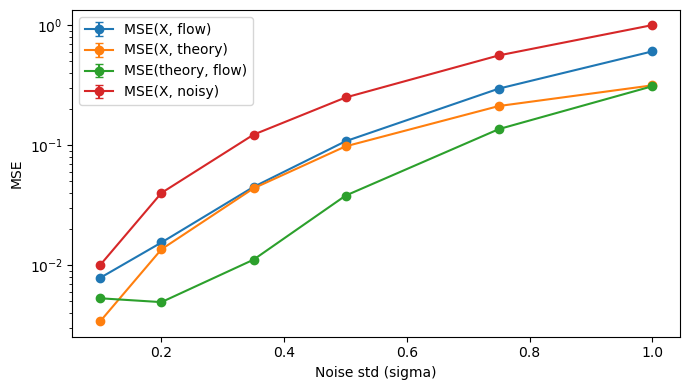

In [38]:
import torch
import matplotlib.pyplot as plt

# --- config ---
sigmas = torch.tensor([0.1, 0.2, 0.35, 0.5, 0.75, 1.0], device=X_test.device)
n_runs = 10
generator = torch.Generator(device=X_test.device).manual_seed(0)

# --- storage: [n_sigmas, n_runs] for each metric ---
mse_x_vs_flow   = torch.empty((len(sigmas), n_runs), device=X_test.device)
mse_x_vs_theory = torch.empty((len(sigmas), n_runs), device=X_test.device)
mse_theory_vs_flow = torch.empty((len(sigmas), n_runs), device=X_test.device)
mse_x_vs_noisy  = torch.empty((len(sigmas), n_runs), device=X_test.device)

# --- sweep ---
with torch.no_grad():
    for i, sigma in enumerate(sigmas):
        for r in range(n_runs):
            noise = torch.randn_like(X_test) * sigma
            X_test_noisy = X_test + noise

            X_test_theory = proj_theory(X_test_noisy)
            X_test_flow   = proj_flow(X_test_noisy)

            # 4 MSEs
            mse_x_vs_flow[i, r] = (X_test - X_test_flow).square().mean()
            mse_x_vs_theory[i, r] = (X_test - X_test_theory).square().mean()
            mse_theory_vs_flow[i, r] = (X_test_theory - X_test_flow).square().mean()
            mse_x_vs_noisy[i, r] = (X_test - X_test_noisy).square().mean()

# --- reduce across runs (mean ± stderr) ---
def mean_stderr(a):  # a: [n_sigmas, n_runs]
    mean = a.mean(dim=1)
    stderr = a.std(dim=1, unbiased=True) / (a.shape[1] ** 0.5)
    return mean, stderr

m1, e1 = mean_stderr(mse_x_vs_flow)
m2, e2 = mean_stderr(mse_x_vs_theory)
m3, e3 = mean_stderr(mse_theory_vs_flow)
m4, e4 = mean_stderr(mse_x_vs_noisy)

# move to cpu for plotting
sig = sigmas.detach().cpu()
series = [
    ("MSE(X, flow)",        m1.detach().cpu(), e1.detach().cpu()),
    ("MSE(X, theory)",      m2.detach().cpu(), e2.detach().cpu()),
    ("MSE(theory, flow)",   m3.detach().cpu(), e3.detach().cpu()),
    ("MSE(X, noisy)",       m4.detach().cpu(), e4.detach().cpu()),
]

# --- plot ---
plt.figure(figsize=(7, 4))
for label, mean, err in series:
    plt.errorbar(sig, mean, yerr=err, marker="o", capsize=3, label=label)

plt.xlabel("Noise std (sigma)")
plt.ylabel("MSE")
plt.yscale("log")  # remove if you prefer linear
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
loaded = torch.load("./../Data/sphere_dataset.pt", map_location="cpu", weights_only = False)
X_test_sphere = torch.tensor(loaded['X_test'], dtype = torch.float32)
proj_flow_sphere = get_flow_matching_projection_fn("sphere", "outputsflow")
proj_theory_sphere = projections.sphere

Loaded flow matching model from outputsflow/sphere_dataset/BEST/model.pt (input_dim=3)


/tmp/ipykernel_2940097/1986789665.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_sphere = torch.tensor(loaded['X_test'], dtype = torch.float32)


In [75]:
loaded = torch.load("./../Data/so3_dataset.pt", map_location="cpu", weights_only = False)
X_test_so3 = torch.tensor(loaded['X_test'], dtype = torch.float32)
proj_flow_so3 = get_flow_matching_projection_fn("so3", "outputsflow")
proj_theory_so3 = projections.so3

Loaded flow matching model from outputsflow/so3_dataset/BEST/model.pt (input_dim=9)


In [76]:
loaded = torch.load("./../Data/cs_dataset.pt", map_location="cpu", weights_only = False)
X_test_cs = torch.tensor(loaded['X_test'], dtype = torch.float32)
proj_flow_cs = get_flow_matching_projection_fn("cs", "outputsflow")
proj_theory_cs = projections.so3

Loaded flow matching model from outputsflow/cs_dataset/BEST/model.pt (input_dim=9)


In [77]:
loaded = torch.load("./../Data/disk_dataset.pt", map_location="cpu", weights_only = False)
X_test_disk = torch.tensor(loaded['X_test'], dtype = torch.float32)
proj_flow_disk = get_flow_matching_projection_fn("disk", "outputsflow")
proj_theory_disk = projections.disk

Loaded flow matching model from outputsflow/disk_dataset/BEST/model.pt (input_dim=2)


In [78]:
loaded = torch.load("./../Data/protein_dataset.pt", map_location="cpu", weights_only = False)
X_train = torch.tensor(loaded["X_train"], dtype=torch.float32)
t = X_train.view(-1, 4, 4)[:, :3, 3]  # Extract translation column
tau = t.std().clamp_min(1e-8)

def normalize_se3_translation(X16: torch.Tensor, tau: torch.Tensor) -> torch.Tensor:
    """
    X16: [N,16] row-major flatten of 4x4.
    Normalizes translation column (rows 0..2, col 3) by tau.
    """
    G = X16.view(-1, 4, 4).clone()
    G[:, :3, 3] = G[:, :3, 3] / tau
    return G.view(-1, 16)

X_test_protein = normalize_se3_translation(torch.tensor(loaded['X_test'], dtype = torch.float32), tau)
proj_flow_protein = get_flow_matching_projection_fn("protein", "outputsflow")
proj_theory_protein = projections.se3

Loaded flow matching model from outputsflow/protein_dataset/BEST/model.pt (input_dim=16)


In [81]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.ticker as mticker

# ----------------------------
# Publication-ish matplotlib defaults (no explicit colors)
# ----------------------------
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
})

# ----------------------------
# CONFIG
# ----------------------------
sigmas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
n_runs = 20
base_seed = 0

# Toggle if you want log scale (often good for MSE curves)
use_logy = True

# ----------------------------
# DATASETS: add 4 more
# Each entry: (name, X_test, proj_theory_fn, proj_flow_fn)
# ----------------------------
DATASETS = [
    ("sphere",   X_test_sphere,   proj_theory_sphere,   proj_flow_sphere),
    ("so3",      X_test_so3,      proj_theory_so3,      proj_flow_so3),
    ("protein",  X_test_protein,  proj_theory_protein,  proj_flow_protein),
    ("disk",     X_test_disk,     proj_theory_disk,     proj_flow_disk),
    ("cs",       X_test_cs,       proj_theory_cs,       proj_flow_cs),
]

def mean_var(x_runs: torch.Tensor):
    # x_runs: [n_sigmas, n_runs]
    mean = x_runs.mean(dim=1)
    var  = x_runs.var(dim=1, unbiased=True)  # variance across runs
    return mean, var.sqrt()

def mean_stderr(x_runs: torch.Tensor):
    # x_runs: [n_sigmas, n_runs]
    mean = x_runs.mean(dim=1)
    stderr = x_runs.std(dim=1, unbiased=True) / (x_runs.shape[1] ** 0.5)
    return mean, stderr

# ----------------------------
# RUN SWEEP
# ----------------------------
results = {}  # name -> (mean_cpu, stderr_cpu)

for d, (name, X_test, proj_theory, proj_flow) in enumerate(DATASETS):
    device = X_test.device
    dtype = X_test.dtype
    sig = sigmas.to(device=device, dtype=dtype)

    # store mse(theory, flow) per sigma/run
    mse_tf = torch.empty((len(sig), n_runs), device=device, dtype=torch.float32)

    with torch.no_grad():
        for i, sigma in tqdm(list(enumerate(sig)), total=len(sig), desc=name):
            for r in range(n_runs):
                noise = torch.randn(X_test.shape, device=device, dtype=dtype) * sigma
                X_noisy = X_test + noise

                X_theory = proj_theory(X_noisy)
                X_flow   = proj_flow(X_noisy)

                eps = 1e-12  # define once (outside loops is fine)
                mse_tf[i, r] = ((X_theory - X_flow).square().mean() / (X_theory.square().mean() + eps)).float()

    m, e = mean_var(mse_tf)
    results[name] = (m.detach().cpu(), e.detach().cpu())



sphere:   0%|          | 0/15 [00:00<?, ?it/s]

so3:   0%|          | 0/15 [00:00<?, ?it/s]

protein:   0%|          | 0/15 [00:00<?, ?it/s]

disk:   0%|          | 0/15 [00:00<?, ?it/s]

cs:   0%|          | 0/15 [00:00<?, ?it/s]

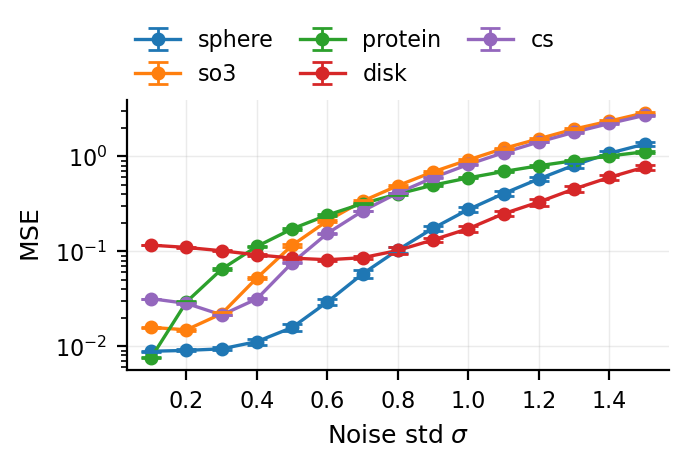

sphere max stderr: 0.06732339411973953
so3 max stderr: 0.04373694956302643
protein max stderr: 0.026141241192817688
disk max stderr: 0.04586569964885712
cs max stderr: 0.015976548194885254


In [82]:
# ----------------------------
# PLOT
# ----------------------------
fig, ax = plt.subplots(figsize=(3.4, 2.3))  # ~single-column figure

sig_cpu = sigmas.detach().cpu()

for name, (m, e) in results.items():
    # If stderr is extremely tiny, caps can disappear; also log-scale hates nonpositive yerr
    e_plot = torch.clamp(e, min=1e-12)

    ax.errorbar(
        sig_cpu, m,
        yerr=e_plot,
        marker="o",
        capsize=3.5,
        capthick=1.0,
        elinewidth=1.0,
        barsabove=True,   # <-- makes error bars draw on top of the line/marker
        label=name,
        zorder=3,
    )

ax.set_xlabel(r"Noise std $\sigma$")
ax.set_ylabel(r"$\mathrm{MSE}$")
if use_logy:
    ax.set_yscale("log")

    # cleaner log ticks (major labeled, minor unlabeled)
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=(2,3,4,5,6,7,8,9)))
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

# lighter major grid only (minor grid is visually noisy on log plots)
ax.grid(True, which="major", linewidth=0.5, alpha=0.25)
ax.grid(False, which="minor")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend above plot so it doesn't cover curves
ax.legend(
    frameon=False,
    ncol=3,
    loc="lower left",
    bbox_to_anchor=(0.0, 1.02),
    borderaxespad=0.0,
    handlelength=2.0,
    columnspacing=1.2,
)

fig.tight_layout(pad=0.6)

# Save vector + high-res raster (optional)
fig.savefig("theory_vs_flow_rel_mse.pdf", bbox_inches="tight")
# fig.savefig("theory_vs_flow_mse.png", bbox_inches="tight")

plt.show()

# Optional sanity check: how big are your error bars?
for name, (m, e) in results.items():
    print(name, "max stderr:", float(e.max()))

In [83]:
import torch

def _flatten_batch(X: torch.Tensor, d_last: int):
    """
    X: [B,d] or [B,S,d]
    Returns X_flat: [N,d], where N=B or B*S
    """
    if X.dim() == 3:
        B, S, D = X.shape
        assert D == d_last, f"Expected last dim {d_last}, got {D}"
        return X.reshape(B * S, D)
    else:
        B, D = X.shape
        assert D == d_last, f"Expected last dim {d_last}, got {D}"
        return X


def sphere_distance_stats(X: torch.Tensor):
    """
    Distance to unit sphere: d(x,S^2) = | ||x|| - 1 |
    X: [B,3] or [B,S,3]
    Returns: (mean_dist, max_dist)
    """
    X_flat = _flatten_batch(X, d_last=3)
    dist = torch.abs(torch.linalg.norm(X_flat, dim=-1) - 1.0)
    return dist.mean().item(), dist.max().item()


def disk_distance_stats(X: torch.Tensor):
    """
    Distance to closed unit disk: d(x,D) = max(0, ||x|| - 1)
    X: [B,2] or [B,S,2]
    Returns: (mean_dist, max_dist)
    """
    X_flat = _flatten_batch(X, d_last=2)
    dist = torch.clamp(torch.linalg.norm(X_flat, dim=-1) - 1.0, min=0.0)
    return dist.mean().item(), dist.max().item()


def so3_distance_stats(R9: torch.Tensor):
    """
    "Distance-like" constraint violations for SO(3), reporting two metrics:
      - orth_dist = || R R^T - I ||_F
      - det_dist  = |det(R) - 1|
    R9: [B,9] or [B,S,9] (row-major flatten)
    Returns:
      (orth_mean, orth_max), (det_mean, det_max)
    """
    R9_flat = _flatten_batch(R9, d_last=9)
    R = R9_flat.reshape(-1, 3, 3)

    I = torch.eye(3, device=R.device, dtype=R.dtype).expand(R.shape[0], 3, 3)
    orth_dist = torch.linalg.norm(R @ R.transpose(-1, -2) - I, dim=(-2, -1))
    det_dist = torch.abs(torch.linalg.det(R) - 1.0)

    sum_dist = orth_dist + det_dist

    return ((sum_dist.mean().item(), sum_dist.max().item()), 
            (orth_dist.mean().item(), orth_dist.max().item()), 
            (det_dist.mean().item(), det_dist.max().item()),)


def se3_distance_stats(G16: torch.Tensor):
    """
    "Distance-like" constraint violations for SE(3), reporting:
      - orth_dist = || R R^T - I ||_F   (R is top-left 3x3)
      - det_dist  = |det(R) - 1|
      - last_row_dist = || last_row - [0,0,0,1] ||_inf
    G16: [B,16] (row-major flatten)
    Returns:
      (orth_mean, orth_max), (det_mean, det_max), (last_mean, last_max)
    """
    assert G16.dim() == 2 and G16.shape[1] == 16, "Expected G16 shaped [B,16]"
    B = G16.shape[0]
    G = G16.reshape(B, 4, 4)

    R = G[:, :3, :3]
    I = torch.eye(3, device=G.device, dtype=G.dtype).expand(B, 3, 3)
    orth_dist = torch.linalg.norm(R @ R.transpose(-1, -2) - I, dim=(-2, -1))
    det_dist = torch.abs(torch.linalg.det(R) - 1.0)

    last = G[:, 3, :]
    target = torch.tensor([0., 0., 0., 1.], device=G.device, dtype=G.dtype).expand_as(last)
    last_dist = torch.max(torch.abs(last - target), dim=-1).values  # L_inf

    sum_dist = orth_dist + det_dist + last_dist
    return ((sum_dist.mean().item(), sum_dist.max().item()),
            (orth_dist.mean().item(), orth_dist.max().item()),
            (det_dist.mean().item(), det_dist.max().item()),
            (last_dist.mean().item(), last_dist.max().item()))

import torch

def constraint_satisfaction(Y_pred: torch.Tensor, dataset: str):
    """
    Returns constraint violation stats as plain Python floats so you can log them.

    Args
    ----
    Y_pred:
        Model outputs.
        Expected shapes by dataset:
          - "sphere":   [B,3] or [B,S,3]
          - "disk":     [B,2] or [B,S,2]
          - "so3":      [B,9] or [B,S,9]   (row-major 3x3)
          - "cs":       [B,9] or [B,S,9]   (row-major 3x3)  (SO(3))
          - "protein":  [B,16]             (row-major 4x4)  (SE(3))

    dataset:
        One of {"sphere","so3","disk","protein","cs"}.

    Returns
    -------
    const: dict
        A small dict of mean/max distances for the relevant constraints.
        Example keys:
          - sphere/disk: {"mean_dist": ..., "max_dist": ...}
          - so3/cs:      {"mean_orth_dist": ..., "max_orth_dist": ..., "mean_det_dist": ..., "max_det_dist": ...}
          - protein:     adds last-row stats as well.
    """
    ds = dataset.lower().strip()

    if ds == "sphere":
        mean_d, max_d = sphere_distance_stats(Y_pred)
        return {"mean_dist": mean_d, "max_dist": max_d}

    if ds == "disk":
        mean_d, max_d = disk_distance_stats(Y_pred)
        return {"mean_dist": mean_d, "max_dist": max_d}

    if ds in ("so3", "cs"):
        (m_sum, M_sum), (m_orth, M_orth), (m_det, M_det) = so3_distance_stats(Y_pred)
        return {
            "mean_sum_dist": m_sum,
            "max_sum_dist": M_sum,
            "mean_orth_dist": m_orth,
            "max_orth_dist": M_orth,
            "mean_det_dist": m_det,
            "max_det_dist": M_det,
        }

    if ds == "protein":
        (m_sum, M_sum), (m_orth, M_orth), (m_det, M_det), (m_last, M_last) = se3_distance_stats(Y_pred)
        return {
            "mean_sum_dist": m_sum,
            "max_sum_dist": M_sum,
            "mean_orth_dist": m_orth,
            "max_orth_dist": M_orth,
            "mean_det_dist": m_det,
            "max_det_dist": M_det,
            "mean_last_row_dist": m_last,
            "max_last_row_dist": M_last,
        }

    raise ValueError(f"Unknown dataset='{dataset}'. Expected one of: sphere, so3, disk, protein, cs.")

In [84]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.ticker as mticker

# ---- helper: pick the "total distance" key uniformly across datasets ----
def total_manifold_distance(Y_pred: torch.Tensor, dataset: str) -> float:
    stats = constraint_satisfaction(Y_pred, dataset)
    # sphere/disk use mean_dist; so3/cs/protein use mean_sum_dist
    if "mean_sum_dist" in stats:
        return stats["mean_sum_dist"]
    return stats["mean_dist"]

def mean_std(x_runs: torch.Tensor):
    mean = x_runs.mean(dim=1)
    std  = x_runs.std(dim=1, unbiased=True)
    return mean, std

In [85]:
# ----------------------------
# RUN DIST-TO-MANIFOLD SWEEP (FLOW)
# ----------------------------
dist_results = {}  # name -> (mean_cpu, std_cpu)

for d, (name, X_test, proj_theory, proj_flow) in enumerate(DATASETS):
    device = X_test.device
    dtype = X_test.dtype
    sig = sigmas.to(device=device, dtype=dtype)

    # per sigma/run: mean total distance to manifold (float)
    dist_tf = torch.empty((len(sig), n_runs), device="cpu", dtype=torch.float32)

    with torch.no_grad():
        for i, sigma in tqdm(list(enumerate(sig)), total=len(sig), desc=f"{name} dist"):
            for r in range(n_runs):
                noise = torch.randn(X_test.shape, device=device, dtype=dtype) * sigma
                X_noisy = X_test + noise

                X_flow = proj_flow(X_noisy)

                # get scalar mean distance (python float) using your code
                dist_tf[i, r] = float(total_manifold_distance(X_flow, name))

    m, s = mean_std(dist_tf)  # mean/std across runs
    dist_results[name] = (m.detach().cpu(), s.detach().cpu())

sphere dist:   0%|          | 0/15 [00:00<?, ?it/s]

so3 dist:   0%|          | 0/15 [00:00<?, ?it/s]

protein dist:   0%|          | 0/15 [00:00<?, ?it/s]

disk dist:   0%|          | 0/15 [00:00<?, ?it/s]

cs dist:   0%|          | 0/15 [00:00<?, ?it/s]

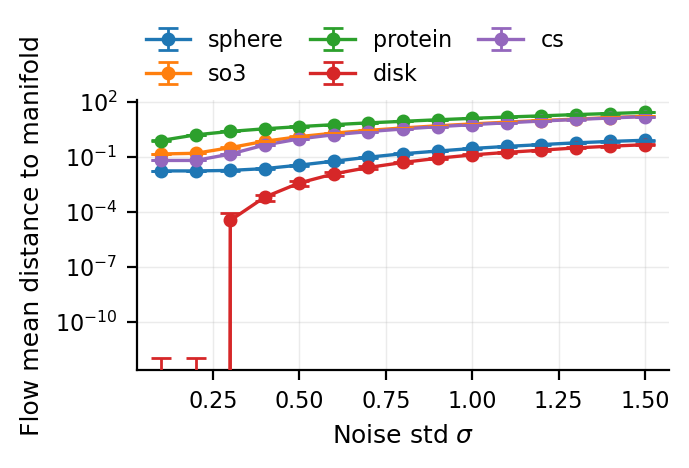

In [87]:
# ----------------------------
# PLOT 2: Flow distance to manifold
# ----------------------------
fig2, ax2 = plt.subplots(figsize=(3.4, 2.3))

sig_cpu = sigmas.detach().cpu()

for name, (m, s) in dist_results.items():
    s_plot = torch.clamp(s, min=1e-12)
    ax2.errorbar(
        sig_cpu, m,
        yerr=s_plot,
        marker="o",
        capsize=3.5,
        capthick=1.0,
        elinewidth=1.0,
        barsabove=True,
        label=name,
        zorder=3,
    )

ax2.set_xlabel(r"Noise std $\sigma$")
ax2.set_ylabel(r"Flow mean distance to manifold")
ax2.set_yscale("log")  # usually right for these

ax2.yaxis.set_major_locator(mticker.LogLocator(base=10))
ax2.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=(2,3,4,5,6,7,8,9)))
ax2.yaxis.set_minor_formatter(mticker.NullFormatter())

ax2.grid(True, which="major", linewidth=0.5, alpha=0.25)
ax2.grid(False, which="minor")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

ax2.legend(
    frameon=False,
    ncol=3,
    loc="lower left",
    bbox_to_anchor=(0.0, 1.02),
    borderaxespad=0.0,
    handlelength=2.0,
    columnspacing=1.2,
)

fig2.tight_layout(pad=0.6)

# Save vector + high-res raster (optional)
fig2.savefig("theory_vs_flow_dist_to_manifold.pdf", bbox_inches="tight")

plt.show()